In [1]:
import math
import matplotlib.pyplot as plt
import random

In [2]:
def read_tsp(filename):
    res=[]
    with open(filename) as falka:
        x=falka.readline()
        while x:
            res.append(x)
            x=falka.readline()
    res=res[6:-1]
    res=[x[:-1].split(' ') for x in res]
    res=[[int(y) for y in x] for x in res]
    return res

def calc_matrix(res):
    C=len(res)
    matrix=[]
    for i in range(C):
        matrix.append([0]*C)

    for i in range(C):
        for j in range(C):
            matrix[i][j]=(res[i][1]-res[j][1])*(res[i][1]-res[j][1])+(res[i][2]-res[j][2])*(res[i][2]-res[j][2])
            matrix[i][j]=round(math.sqrt(matrix[i][j]))
    return matrix

system={}
for x in ['kroA100.tsp', 'kroB100.tsp']:
    system[x]={}
    system[x]['res']=read_tsp(x)
    system[x]['matrix']=calc_matrix(system[x]['res'])
    system[x]['size']=len(system[x]['matrix'])

In [3]:
def greedy_closest_neigh_comparer(matrix, last, start, cur, compared):
    if matrix[last][compared]<matrix[last][cur]:
        return True
    return False
        
def greedy_cycle_comparer(matrix, last, start, cur, compared):
    if matrix[last][compared]+matrix[start][compared]<matrix[last][cur]+matrix[start][cur]:
        return True
    return False

def double_regret(matrix, pathway, j, k=2, cnst=1):
    regrets=[]
    ln=len(pathway)
    for i in range(0, ln):
        v1=pathway[i]
        v2=pathway[(i+1)%ln]
        regrets.append((matrix[v1][j]+matrix[v2][j]-matrix[v1][v2], i))
    regrets=sorted(regrets, key=lambda x: x[0])
    
    sum_of_regrets=-cnst*regrets[0][0]#-regrets[0][0]
    for i in range(1, min(ln, k)):
        sum_of_regrets=sum_of_regrets+regrets[i][0]-regrets[0][0]
    return sum_of_regrets, regrets[0][1]+1
        

def general_heuristic(matrix, start, comparer, regrets=False, k_reg=2, cnst=1):
    ln=len(matrix)//2
    allez=len(matrix)
    last, elems, cur, path, devoured=start, 1, -1, [start], [0]*allez
    devoured[start]=1
    fortress_of_regrets=[0, -1]
    
    while len(path)<ln:
        for j in range(allez):
            if devoured[j]==1:
                continue
                
            if regrets==True:
                partial_regret=comparer(matrix, path, j, k_reg, cnst)
                if cur==-1 or partial_regret[0]>fortress_of_regrets[0]:
                    fortress_of_regrets=partial_regret
                    cur=j
            if regrets==False and (cur==-1 or comparer(matrix, last, path[0], cur, j)):
                cur=j
        
        last, cur=cur, -1
        devoured[last]=1
        if regrets==False:
            path.append(last)
        else:
            path.insert(fortress_of_regrets[1], last)
        fortress_of_regrets=[0, -1]
    return path

def cost(pathway, matrix):
    ln=len(pathway)
    summa=0
    for i,x in enumerate(pathway):
        summa+=matrix[x][pathway[(i+1)%ln]]
    return summa

reality=[('greed', [greedy_closest_neigh_comparer]), ('cycle', [greedy_cycle_comparer]), 
        ('2reg-1', [double_regret, True, 2, 0]), ('2reg-2', [double_regret, True, 2, 1])]

for x in system:
    indexes=list(range(1, 100))
    random.shuffle(indexes)
    indexes=indexes[:50]
    
    SIZE=system[x]['size']
    matrix=system[x]['matrix']
    res=system[x]['res']
    system[x]['full_ways']={}
    system[x]['costs']={}
    for y in reality:
        system[x]['full_ways'][y[0]]=[]
        system[x]['costs'][y[0]]=[]
        for i in indexes:
            way=general_heuristic(matrix, i, *y[1])
            system[x]['full_ways'][y[0]].append(way)
            system[x]['costs'][y[0]].append(cost(way, matrix))

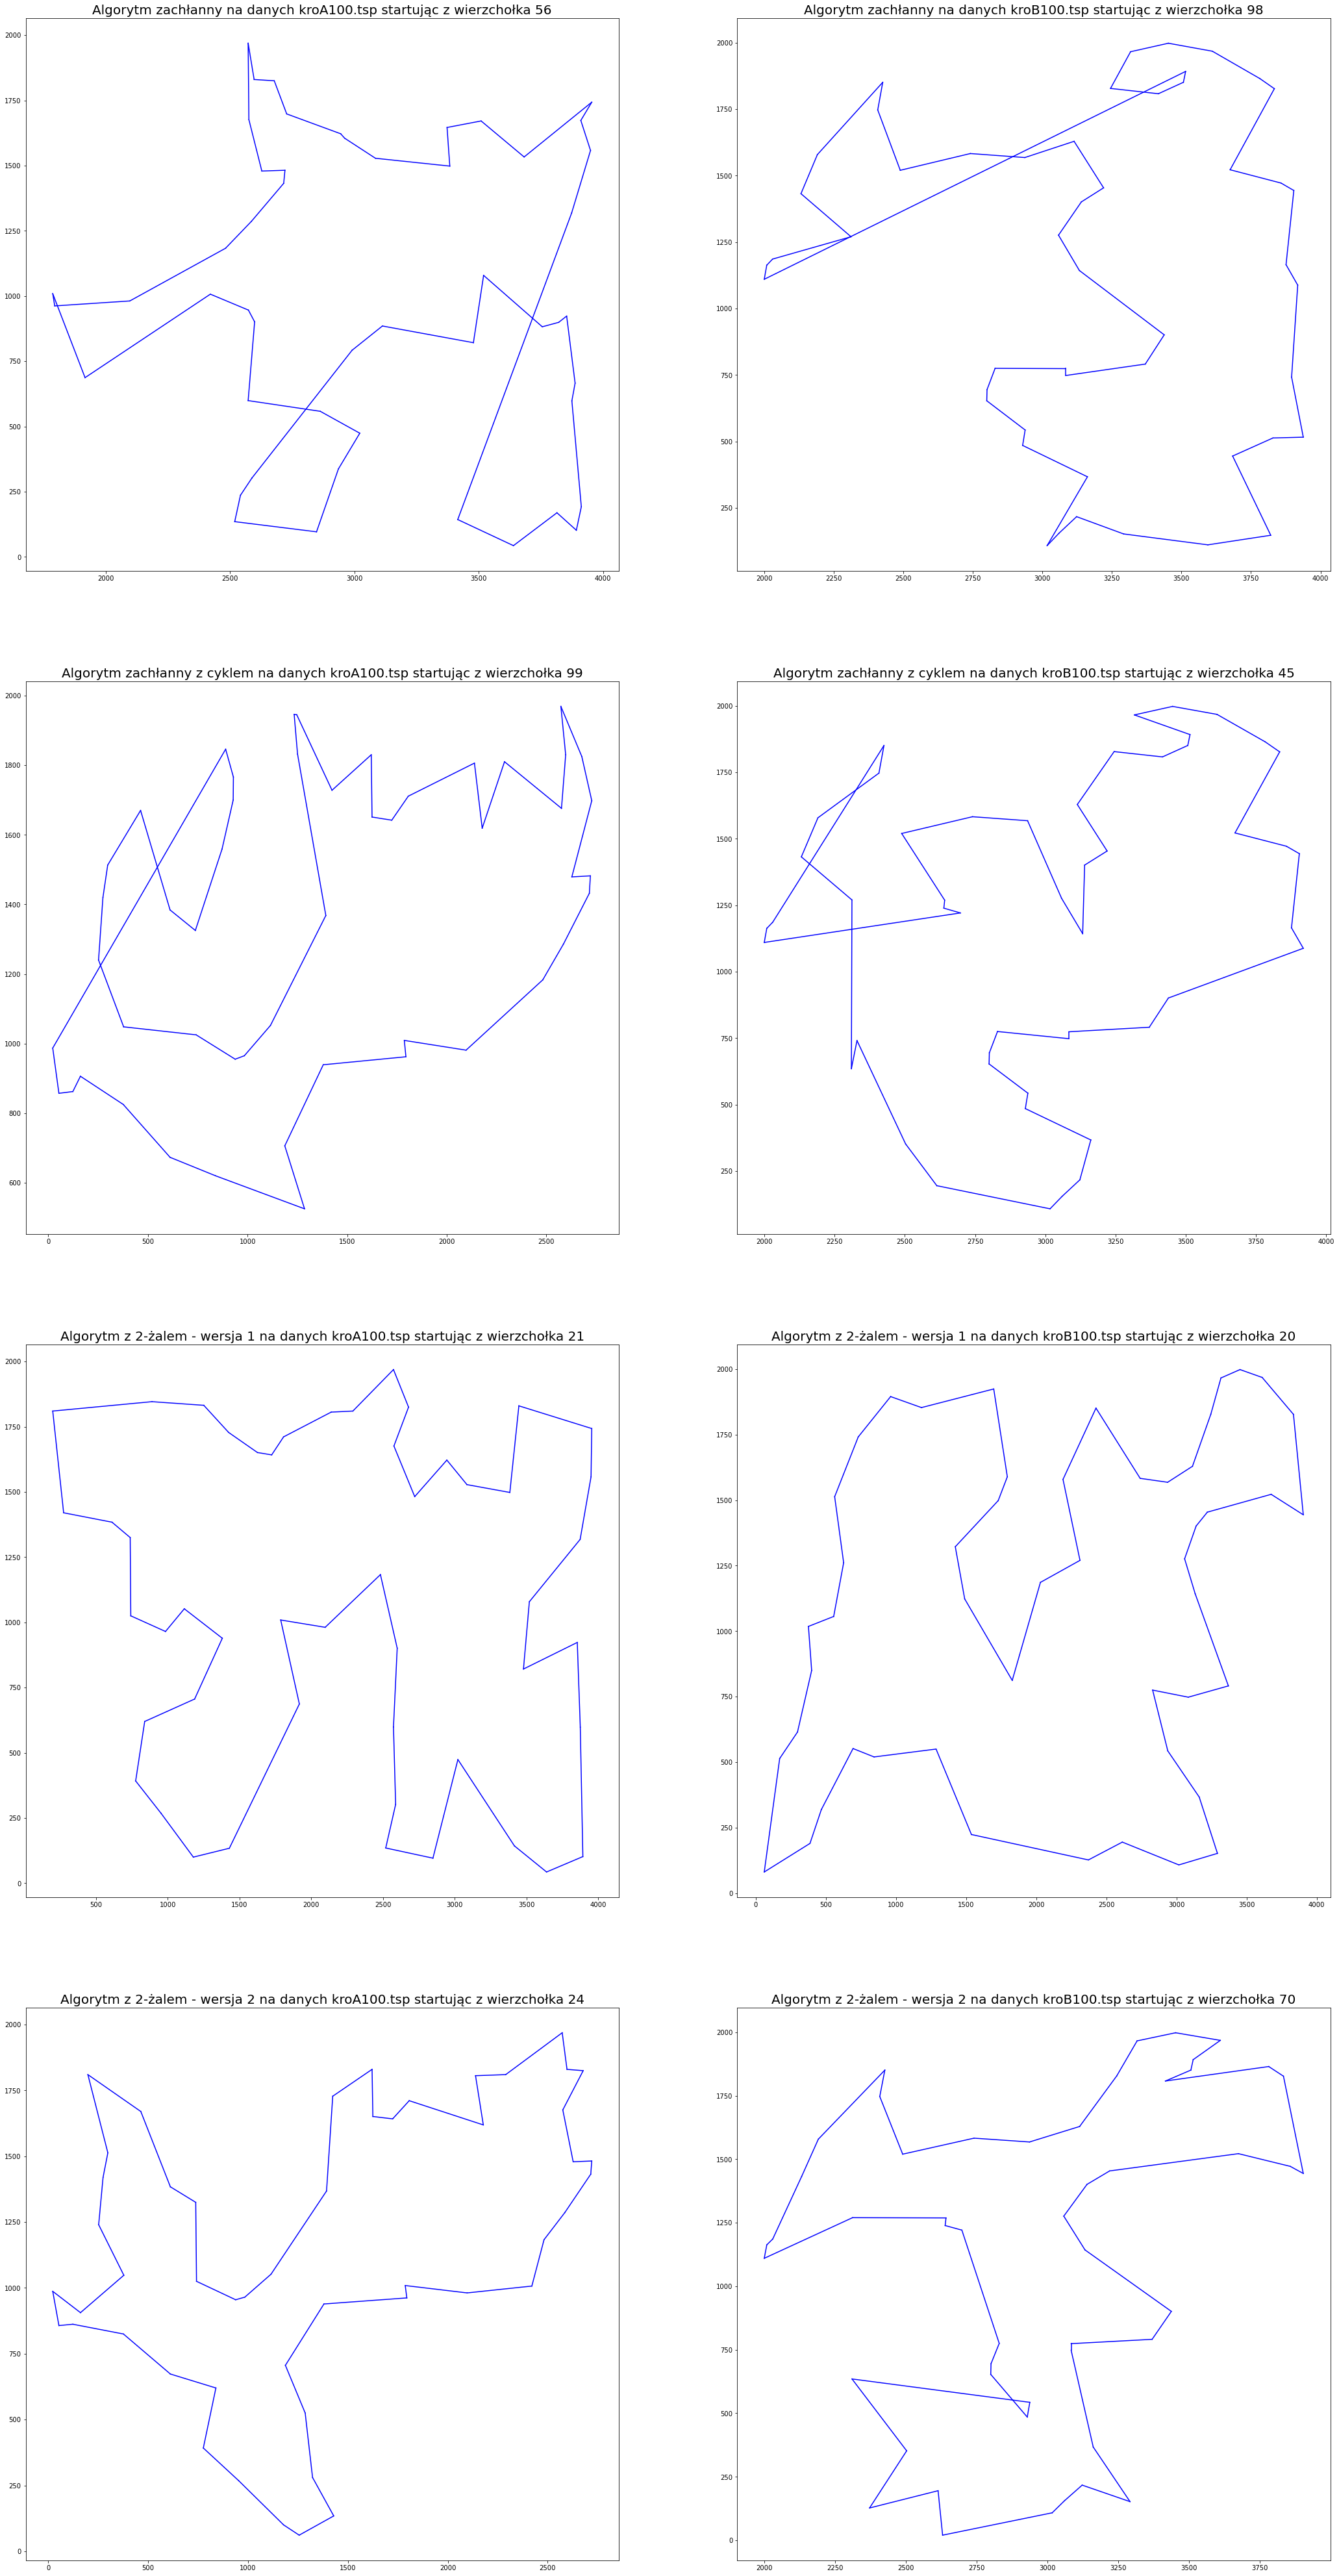

In [4]:
def print_map(res, path, ax):
    ln=len(path)
    for x, v1 in enumerate(path):
        v2=path[(x+1)%ln]
        ax.plot([res[v1][1], res[v2][1]], [res[v1][2], res[v2][2]], color='blue')

        
fig, ax=plt.subplots(4, 2, figsize=(36, 72))
mapp={'kroA100.tsp':0, 'kroB100.tsp':1, 'greed':0, 'cycle':1, '2reg-1':2, '2reg-2':3}
naming={'greed':'zachłanny', 'cycle':'zachłanny z cyklem', '2reg-1':'z 2-żalem - wersja 1', '2reg-2':'z 2-żalem - wersja 2'}
for x in system:
    for y in system[x]['full_ways']:
        cur_min, elem=system[x]['costs'][y][0], 0
        
        for i,v in enumerate(indexes):
            if system[x]['costs'][y][i]<cur_min:
                cur_min, elem=system[x]['costs'][y][i], i
        axis=ax[mapp[y]][mapp[x]]
        print_map(system[x]['res'], system[x]['full_ways'][y][elem], axis)
        axis.set_title(f'Algorytm {naming[y]} na danych {x} startując z wierzchołka {indexes[elem]}', size=20)
plt.savefig("heury.svg")

In [5]:
for x in system:
    for y in system[x]['costs']:
        real=system[x]['costs'][y]
        print(f'{x} & {naming[y]} & {min(real)} & {sum(real)/len(real)} & {max(real)} \\\\ \\hline')

kroA100.tsp & zachłanny & 11491 & 12838.16 & 14874 \\ \hline
kroA100.tsp & zachłanny z cyklem & 11284 & 14293.98 & 18139 \\ \hline
kroA100.tsp & z 2-żalem - wersja 1 & 15225 & 16184.5 & 17235 \\ \hline
kroA100.tsp & z 2-żalem - wersja 2 & 10450 & 11902.42 & 13625 \\ \hline
kroB100.tsp & zachłanny & 10478 & 13386.3 & 15982 \\ \hline
kroB100.tsp & zachłanny z cyklem & 10417 & 13901.02 & 19102 \\ \hline
kroB100.tsp & z 2-żalem - wersja 1 & 14511 & 15701.8 & 17171 \\ \hline
kroB100.tsp & z 2-żalem - wersja 2 & 10244 & 11401.06 & 13109 \\ \hline
